# Some Configurtions

In [15]:
!pip install torch nibabel numpy pandas tensorflow scikit-learn scikit-image ssqueezepy timm pytorch-lightning mne scikit-learn tensorboard tensorboardX ipywidgets jupyter_contrib_nbextensions

python(69080) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


ERROR: Could not find a version that satisfies the requirement keras_video (from versions: none)
ERROR: No matching distribution found for keras_video


In [16]:
import torch
# Check if MPS is available
if torch.backends.mps.is_available():
    device = torch.device("mps")
    print("MPS backend is available, using M3 GPU.")
else:
    device = torch.device("cpu")
    print("MPS backend is not available, using CPU.")

MPS backend is available, using M3 GPU.


In [3]:
# import os
# import nibabel as nib
# import numpy as np
# import matplotlib.pyplot as plt

# # Define the main directory
# main_directory = '/Users/rayanbeshawri/ds004856/'

# # Lists to store paths for PET and T1w images
# pet_files = []
# anat_files = []

# # Traverse the directory and collect PET and T1w image paths
# for root, dirs, files in os.walk(main_directory):
#     for file in files:
#         if file.endswith('.nii.gz') and 'ses-wave1' in file:
#             file_path = os.path.join(root, file)
#             if os.path.exists(file_path):
#                 if 'pet' in file:
#                     pet_files.append(file_path)
#                 elif 'T1w' in file or 't1' in file:
#                     anat_files.append(file_path)

# # Helper function to plot a grid of images
# def plot_image_grid(file_paths, grid_title, ncols=5):
#     n_images = len(file_paths)
#     nrows = (n_images + ncols - 1) // ncols  # Calculate required rows based on column count

#     fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(15, nrows * 3))
#     fig.suptitle(grid_title, fontsize=16)  # Title for the entire grid
    
#     # Flatten axes for easy iteration if ncols or nrows > 1
#     axes = axes.flatten() if n_images > 1 else [axes]

#     for i, file_path in enumerate(file_paths):
#         # Load and get the middle slice of each image
#         img = nib.load(file_path).get_fdata()
#         slice_index = img.shape[2] // 2
#         axes[i].imshow(img[:, :, slice_index], cmap='gray')
#         axes[i].axis('off')  # Turn off axis to remove ticks and titles

#     # Hide any remaining empty subplots
#     for j in range(i + 1, len(axes)):
#         axes[j].axis('off')

#     # Adjust layout for clean display
#     plt.tight_layout(rect=[0, 0, 1, 0.96])  # Leave room for suptitle
#     plt.subplots_adjust(wspace=0.05, hspace=0.05)  # Adjust spacing between images
#     plt.show()

# # Display grids for PET and T1w images
# plot_image_grid(pet_files, grid_title='PET Images', ncols=5)
# plot_image_grid(anat_files, grid_title='T1w Images', ncols=5)

In [4]:
# import os
# import pandas as pd
# import re

# # Define directories and files
# main_directory = '/Users/rayanbeshawri/ds004856/'
# label_file = '/Users/rayanbeshawri/ds004856/labeled_participants.tsv'
# output_csv = '/Users/rayanbeshawri/ds004856/subject_image_paths.csv'

# # Load labels from the TSV file
# labels_df = pd.read_csv(label_file, sep='\t')
# labels_df.set_index('subject', inplace=True)  # Set subject as the index for easier lookup

# # Prepare lists to collect paths
# mri_paths = {}
# pet_paths = {}

# # Traverse directory and collect paths
# for root, dirs, files in os.walk(main_directory):
#     for file in files:
#         if file.endswith('.nii.gz'):
#             # Extract subject ID
#             match = re.search(r'(sub-\d+)', file)
#             if match:
#                 subject_id = match.group(1)
                
#                 # Classify as MRI or PET based on filename pattern
#                 if 'T1w' in file and 'ses-wave1' in file:
#                     mri_paths[subject_id] = os.path.join(root, file)
#                 elif 'pet' in file and 'ses-wave1' in file:
#                     pet_paths[subject_id] = os.path.join(root, file)

# # Prepare rows for CSV output
# data = []
# for subject_id, label in labels_df['diagnosis'].items():
#     mri_path = mri_paths.get(subject_id, None)
#     pet_path = pet_paths.get(subject_id, None)
    
#     # Add row only if both MRI and PET paths exist
#     if mri_path and pet_path:
#         data.append({
#             'subject': subject_id,
#             'mri_image_path': mri_path,
#             'pet_image_path': pet_path,
#             'diagnosis': label
#         })

# # Convert to DataFrame and save as CSV
# df = pd.DataFrame(data)
# df.to_csv(output_csv, index=False)

# print(f"CSV file saved to {output_csv}")

In [2]:
import os
import nibabel as nib
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import train_test_split, KFold
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv3D, MaxPooling3D, Flatten, Dense, Dropout, Input, BatchNormalization, Add, Activation, GlobalAveragePooling3D
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.applications import ResNet50
from tensorflow.keras import backend as K
from tensorflow.keras import metrics
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import classification_report
from tensorflow.keras.models import Model

**Data pre-processing**

In [6]:
# Load CSV file
data = pd.read_csv('/Users/rayanbeshawri/ds004856/subject_image_paths.csv')
print("CSV data loaded successfully:")

# Define function to load and preprocess the MRI/PET images
def load_nifti_image(file_path, target_shape=(64, 64, 64)):
    img = nib.load(file_path).get_fdata()
    img = np.array(img)
    img = resize_image(img, target_shape)
    img = normalize_image(img)
    return img

# Resize images to a common shape
def resize_image(img, target_shape):
    from skimage.transform import resize
    resized_img = resize(img, target_shape, mode='constant', anti_aliasing=True)
    return resized_img

# Normalize image
def normalize_image(img):
    normalized_img = (img - np.min(img)) / (np.max(img) - np.min(img))
    return normalized_img

# Load images and labels
mri_images = []
pet_images = []
labels = []

for index, row in data.iterrows():
    mri_image = load_nifti_image(row['mri_image_path'])
    pet_image = load_nifti_image(row['pet_image_path'])
    label = 0 if row['diagnosis'] == 'CN' else 1  # Encode 'CN' as 0, 'AD' as 1
    
    mri_images.append(mri_image)
    pet_images.append(pet_image)
    labels.append(label)

mri_images = np.array(mri_images)
pet_images = np.array(pet_images)
labels = np.array(labels)

print(f"Shape of MRI images array: {mri_images.shape}")
print(f"Shape of PET images array: {pet_images.shape}")
print(f"Labels array shape: {labels.shape}")

CSV data loaded successfully:
Shape of MRI images array: (295, 64, 64, 64)
Shape of PET images array: (295, 64, 64, 64)
Labels array shape: (295,)


In [7]:
def CNN_3D(input_shape=(64, 64, 64, 1), num_classes=2, dropout_rate=0.5):
    # Input layer
    input_layer = Input(shape=input_shape)

    x = Conv3D(32, (3, 3, 3), padding='same', activation='relu')(input_layer)
    x = BatchNormalization()(x)
    x = Conv3D(32, (3, 3, 3), padding='same', activation='relu')(x)
    x = BatchNormalization()(x)
    x = MaxPooling3D(pool_size=(2, 2, 2))(x)

    x_res = Conv3D(64, (1, 1, 1), padding='same', activation='relu')(x)  # Residual connection
    x = Conv3D(64, (3, 3, 3), padding='same', activation='relu')(x)
    x = BatchNormalization()(x)
    x = Conv3D(64, (3, 3, 3), padding='same', activation='relu')(x)
    x = BatchNormalization()(x)
    x = Add()([x, x_res])  # Add the residual connection
    x = MaxPooling3D(pool_size=(2, 2, 2))(x)

    x_res = Conv3D(128, (1, 1, 1), padding='same', activation='relu')(x)  # Residual connection
    x = Conv3D(128, (3, 3, 3), padding='same', activation='relu')(x)
    x = BatchNormalization()(x)
    x = Conv3D(128, (3, 3, 3), padding='same', activation='relu')(x)
    x = BatchNormalization()(x)
    x = Add()([x, x_res])  # Add the residual connection
    x = MaxPooling3D(pool_size=(2, 2, 2))(x)

    x = GlobalAveragePooling3D()(x)
    x = Dense(256, activation='relu')(x)
    x = Dropout(dropout_rate)(x)
    x = Dense(128, activation='relu')(x)
    x = Dropout(dropout_rate)(x)
    output_layer = Dense(num_classes, activation='softmax')(x)  # Multi-class classification

    # Model definition
    model = Model(inputs=input_layer, outputs=output_layer)

    # Compile the model
    model.compile(
        optimizer=Adam(learning_rate=0.0001),
        loss='categorical_crossentropy',
        metrics=['accuracy', 'AUC', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()]
    )

    return model

**MRI Images Training**

In [8]:
# Train/test split
X_train, X_test, y_train, y_test = train_test_split(mri_images, labels, test_size=0.2, random_state=42)
print("Data split into training and testing sets.")
print(f"Training data shape: {X_train.shape}, Test data shape: {X_test.shape}")

# One-hot encode labels
y_train = to_categorical(y_train, num_classes=2)
y_test = to_categorical(y_test, num_classes=2)
print(f"One-hot encoded labels: y_train shape {y_train.shape}, y_test shape {y_test.shape}")

# Prepare MRI images for training (expand dimensions to fit model input)
X_train = np.expand_dims(X_train, axis=-1)
X_test = np.expand_dims(X_test, axis=-1)
print(f"Expanded training data shape: {X_train.shape}, Expanded test data shape: {X_test.shape}")

# Initialize and train model
model = CNN_3D(input_shape=(64, 64, 64, 1))

# Train the model
print("Starting model training...")
history = model.fit(X_train, y_train, epochs=3, batch_size=8, validation_data=(X_test, y_test))

# Evaluate model
print("Evaluating model on test data...")
result = model.evaluate(X_test, y_test)
loss, accuracy = result[0], result[1]
print(f"Test Loss: {loss:.4f}, Test Accuracy: {accuracy:.4f}")

Data split into training and testing sets.
Training data shape: (236, 64, 64, 64), Test data shape: (59, 64, 64, 64)
One-hot encoded labels: y_train shape (236, 2), y_test shape (59, 2)
Expanded training data shape: (236, 64, 64, 64, 1), Expanded test data shape: (59, 64, 64, 64, 1)
Starting model training...
Epoch 1/3
30/30 ━━━━━━━━━━━━━━━━━━━━ 210s 7s/step - AUC: 0.4691 - accuracy: 0.4597 - loss: 1.4979 - precision: 0.4597 - recall: 0.4597 - val_AUC: 0.5000 - val_accuracy: 0.3729 - val_loss: 0.6935 - val_precision: 0.3729 - val_recall: 0.3729
Epoch 2/3
30/30 ━━━━━━━━━━━━━━━━━━━━ 211s 7s/step - AUC: 0.4263 - accuracy: 0.4462 - loss: 1.1743 - precision: 0.4462 - recall: 0.4462 - val_AUC: 0.6188 - val_accuracy: 0.6271 - val_loss: 0.6747 - val_precision: 0.6271 - val_recall: 0.6271
Epoch 3/3
30/30 ━━━━━━━━━━━━━━━━━━━━ 217s 7s/step - AUC: 0.4771 - accuracy: 0.4724 - loss: 0.9299 - precision: 0.4724 - recall: 0.4724 - val_AUC: 0.6288 - val_accuracy: 0.6271 - val_loss: 0.6610 - val_precisio

**PET Images Training**

In [9]:
# Data split
X_train, X_test, y_train, y_test = train_test_split(pet_images, labels, test_size=0.2, random_state=42)
print("Data split into training and testing sets.")
print(f"Training data shape: {X_train.shape}, Test data shape: {X_test.shape}")

# One-hot encode labels
y_train = to_categorical(y_train, num_classes=2)
y_test = to_categorical(y_test, num_classes=2)
print(f"One-hot encoded labels: y_train shape {y_train.shape}, y_test shape {y_test.shape}")

# Cross-validation setup using KFold
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Prepare MRI images for training (expand dimensions to fit model input)
X_train = np.expand_dims(X_train, axis=-1)
X_test = np.expand_dims(X_test, axis=-1)
print(f"Expanded training data shape: {X_train.shape}, Expanded test data shape: {X_test.shape}")

# Initialize and train model
model = CNN_3D(input_shape=(64, 64, 64, 1))  # Use this or create_3d_resnet() for transfer learning

# Callbacks for optimization
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3)

# Cross-validation loop
for train_idx, val_idx in kf.split(X_train):
    X_train_cv, X_val_cv = X_train[train_idx], X_train[val_idx]
    y_train_cv, y_val_cv = y_train[train_idx], y_train[val_idx]
    
    # Train the model
    history = model.fit(X_train_cv, y_train_cv, epochs=3, batch_size=8, 
                        validation_data=(X_val_cv, y_val_cv), 
                        callbacks=[early_stop, reduce_lr])

    # Evaluate on validation set
    val_loss, val_accuracy, val_auc, val_precision, val_recall = model.evaluate(X_val_cv, y_val_cv)
    print(f"Validation Loss: {val_loss}, Accuracy: {val_accuracy}, AUC: {val_auc}, Precision: {val_precision}, Recall: {val_recall}")
    
    # Evaluate on test data
    test_loss, test_accuracy, test_auc, test_precision, test_recall = model.evaluate(X_test, y_test)
    print(f"Test Loss: {test_loss}, Accuracy: {test_accuracy}, AUC: {test_auc}, Precision: {test_precision}, Recall: {test_recall}")

# Test classification report
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test, axis=1)

print("Classification Report:")
print(classification_report(y_true_classes, y_pred_classes))

Data split into training and testing sets.
Training data shape: (236, 64, 64, 64), Test data shape: (59, 64, 64, 64)
One-hot encoded labels: y_train shape (236, 2), y_test shape (59, 2)
Expanded training data shape: (236, 64, 64, 64, 1), Expanded test data shape: (59, 64, 64, 64, 1)
Epoch 1/3
24/24 ━━━━━━━━━━━━━━━━━━━━ 186s 8s/step - AUC: 0.4380 - accuracy: 0.4732 - loss: 1.3794 - precision_1: 0.4732 - recall_1: 0.4732 - val_AUC: 0.4670 - val_accuracy: 0.4792 - val_loss: 0.6944 - val_precision_1: 0.4792 - val_recall_1: 0.4792 - learning_rate: 1.0000e-04
Epoch 2/3
24/24 ━━━━━━━━━━━━━━━━━━━━ 183s 8s/step - AUC: 0.5007 - accuracy: 0.4858 - loss: 0.8943 - precision_1: 0.4858 - recall_1: 0.4858 - val_AUC: 0.4792 - val_accuracy: 0.4792 - val_loss: 0.7054 - val_precision_1: 0.4792 - val_recall_1: 0.4792 - learning_rate: 1.0000e-04
Epoch 3/3
24/24 ━━━━━━━━━━━━━━━━━━━━ 188s 8s/step - AUC: 0.5174 - accuracy: 0.5186 - loss: 0.8999 - precision_1: 0.5186 - recall_1: 0.5186 - val_AUC: 0.5330 - val_a

KeyboardInterrupt: 

In [17]:
import os
import numpy as np
import mne
import matplotlib.pyplot as plt
from glob import glob
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense, Dropout, Input
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import GroupKFold
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.metrics import AUC, Precision, Recall
import torch
import torch.nn as nn
from sklearn.model_selection import train_test_split
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import GroupKFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
from sklearn.model_selection import StratifiedKFold
import pandas as pd
from sklearn.model_selection import ParameterGrid
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_auc_score

In [18]:
mne.set_log_level('ERROR')
# Paths to EEG files
all_files_path = glob('/Users/rayanbeshawri/Downloads/Senior/DataSets/EEG Dataset/derivatives/Preprocessed EEG/*.fif')
# Divide files into patient and control groups
files_path = {
    'healthy': [file for file in all_files_path if int(file.split('_')[0].split('-')[1]) >= 37],
    'patients': [file for file in all_files_path if int(file.split('_')[0].split('-')[1]) <= 36]
}
print("All files found:", all_files_path)
print("Patient files:", files_path['patients'])
print("Control files:", files_path['healthy'])

All files found: ['/Users/rayanbeshawri/Downloads/Senior/DataSets/EEG Dataset/derivatives/Preprocessed EEG/sub-064_task-eyesclosed_eeg.fif', '/Users/rayanbeshawri/Downloads/Senior/DataSets/EEG Dataset/derivatives/Preprocessed EEG/sub-015_task-eyesclosed_eeg.fif', '/Users/rayanbeshawri/Downloads/Senior/DataSets/EEG Dataset/derivatives/Preprocessed EEG/sub-024_task-eyesclosed_eeg.fif', '/Users/rayanbeshawri/Downloads/Senior/DataSets/EEG Dataset/derivatives/Preprocessed EEG/sub-055_task-eyesclosed_eeg.fif', '/Users/rayanbeshawri/Downloads/Senior/DataSets/EEG Dataset/derivatives/Preprocessed EEG/sub-046_task-eyesclosed_eeg.fif', '/Users/rayanbeshawri/Downloads/Senior/DataSets/EEG Dataset/derivatives/Preprocessed EEG/sub-037_task-eyesclosed_eeg.fif', '/Users/rayanbeshawri/Downloads/Senior/DataSets/EEG Dataset/derivatives/Preprocessed EEG/sub-009_task-eyesclosed_eeg.fif', '/Users/rayanbeshawri/Downloads/Senior/DataSets/EEG Dataset/derivatives/Preprocessed EEG/sub-006_task-eyesclosed_eeg.fif'

In [12]:
# from sklearn.preprocessing import OneHotEncoder

# def preprocess_data(files_path, duration=60, overlap=0):
#     """
#     Preprocess the preprocessed EEG data, create epochs, and prepare train-test split.
#     Args:
#         files_path (dict): A dictionary with keys 'healthy' and 'patients', each containing lists of file paths to EEG data.
#         duration (int): Epoch duration in seconds.
#         overlap (int): Overlap between epochs in seconds.

#     Returns:
#         train_data, train_labels, test_data, test_labels: Preprocessed train and test data and their labels.
#     """
#     # Helper function to read and epoch the data
#     def read_data(file_path):
#         try:
#             data = mne.io.read_raw_fif(file_path, preload=True)
#         except Exception as e:
#             print(f"Error loading file {file_path}: {e}")
#             raise e
#         # Create fixed-length epochs
#         epochs = mne.make_fixed_length_epochs(data, duration=duration, overlap=overlap)
#         return epochs.get_data()  # Shape: (trials, channels, samples)

#     # Process EEG data for all files
#     patients_epochs_array = [read_data(file_path) for file_path in files_path['patients']]
#     control_epochs_array = [read_data(file_path) for file_path in files_path['healthy']]

#     # Labels: 1 for AD (patients) and 0 for CN (healthy)
#     patients_labels = [len(epochs) * [1] for epochs in patients_epochs_array]
#     control_labels = [len(epochs) * [0] for epochs in control_epochs_array]

#     # Combine data and labels
#     data_array = np.vstack(patients_epochs_array + control_epochs_array)  # Shape: (total_trials, channels, samples)
#     label_array = np.hstack(patients_labels + control_labels)  # Shape: (total_trials,)

#     # **One-hot encode the labels**
#     label_array = np.eye(2)[label_array]  # Convert to one-hot: Shape (total_trials, 2)

#     # Standardize the data
#     scaler = StandardScaler()
#     data_array = np.array([scaler.fit_transform(epoch.T).T for epoch in data_array])

#     # Reshape for ChronoNet: (samples, time_steps, channels)
#     data_array = np.moveaxis(data_array, 1, 2)  # Shape: (samples, time_steps, channels)

#     # Train-test split
#     train_data, test_data, train_labels, test_labels = train_test_split(
#         data_array, label_array, test_size=0.2, stratify=label_array[:, 1], random_state=42
#     )
#     print("Training label distribution:", np.sum(train_labels, axis=0))
#     print("Testing label distribution:", np.sum(test_labels, axis=0))

#     return train_data, train_labels, test_data, test_labels

In [23]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import mne
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

def preprocess_data(files_path, duration=60, overlap=0):
    """
    Preprocess EEG data, create epochs, prepare train-test split, and perform EDA.
    Args:
        files_path (dict): A dictionary with keys 'healthy' and 'patients', each containing lists of file paths to EEG data.
        duration (int): Epoch duration in seconds.
        overlap (int): Overlap between epochs in seconds.

    Returns:
        train_data, train_labels, test_data, test_labels: Preprocessed train and test data and their labels.
    """
    # Helper function to read and epoch the data
    def read_data(file_path):
        try:
            data = mne.io.read_raw_fif(file_path, preload=True)
        except Exception as e:
            print(f"Error loading file {file_path}: {e}")
            raise e
        # Create fixed-length epochs
        epochs = mne.make_fixed_length_epochs(data, duration=duration, overlap=overlap)
        return epochs.get_data()  # Shape: (trials, channels, samples)

    # Process EEG data for all files
    patients_epochs_array = [read_data(file_path) for file_path in files_path['patients']]
    control_epochs_array = [read_data(file_path) for file_path in files_path['healthy']]

    # Plot the distribution of epochs per group
    patient_epoch_counts = [len(epochs) for epochs in patients_epochs_array]
    control_epoch_counts = [len(epochs) for epochs in control_epochs_array]
    plt.bar(['Patients', 'Healthy'], [sum(patient_epoch_counts), sum(control_epoch_counts)])
    plt.title('Epoch Distribution by Group')
    plt.ylabel('Number of Epochs')
    plt.show()

    # Labels: 1 for AD (patients) and 0 for CN (healthy)
    patients_labels = [len(epochs) * [1] for epochs in patients_epochs_array]
    control_labels = [len(epochs) * [0] for epochs in control_epochs_array]

    # Combine data and labels
    data_array = np.vstack(patients_epochs_array + control_epochs_array)  # Shape: (total_trials, channels, samples)
    label_array = np.hstack(patients_labels + control_labels)  # Shape: (total_trials,)

    # Plot label distribution
    sns.countplot(x=label_array)
    plt.title('Label Distribution')
    plt.xlabel('Labels (0: Healthy, 1: Patients)')
    plt.ylabel('Count')
    plt.show()

    # **One-hot encode the labels**
    label_array = np.eye(2)[label_array]  # Convert to one-hot: Shape (total_trials, 2)

    # Standardize the data
    scaler = StandardScaler()
    data_array = np.array([scaler.fit_transform(epoch.T).T for epoch in data_array])

    # Visualize a sample epoch (standardized)
    plt.plot(data_array[0].T)
    plt.title('Standardized Sample Epoch')
    plt.xlabel('Time (samples)')
    plt.ylabel('Amplitude')
    plt.show()

    # Reshape for ChronoNet: (samples, time_steps, channels)
    data_array = np.moveaxis(data_array, 1, 2)  # Shape: (samples, time_steps, channels)

    # Train-test split
    train_data, test_data, train_labels, test_labels = train_test_split(
        data_array, label_array, test_size=0.2, stratify=label_array[:, 1], random_state=42
    )

    # Display training and testing label distributions
    print("Training label distribution:", np.sum(train_labels, axis=0))
    print("Testing label distribution:", np.sum(test_labels, axis=0))

    # Plot mean signal across channels for the first training sample
    mean_signal = train_data[0].mean(axis=1)
    plt.plot(mean_signal)
    plt.title('Mean Signal Across Channels (Sample 1)')
    plt.xlabel('Time Steps')
    plt.ylabel('Mean Amplitude')
    plt.show()

    return train_data, train_labels, test_data, test_labels

In [24]:
class ChronoNet(nn.Module):
    def __init__(self):
        super(ChronoNet, self).__init__()
        
        # Inception modules
        self.inception1 = Inception(19)  # Input channels: 19
        self.inception2 = Inception(96)  # Output channels of inception1 = 96
        self.inception3 = Inception(96)  # Output channels of inception2 = 96

        # GRU layers
        self.gru1 = nn.GRU(96, 32, batch_first=True)  # Input: 96, Hidden: 32
        self.gru2 = nn.GRU(32, 32, batch_first=True)  # Input: 32, Hidden: 32
        self.gru3 = nn.GRU(64, 32, batch_first=True)  # Concatenated input: 64
        self.gru4 = nn.GRU(96, 2, batch_first=True)   # Concatenated input: 96, Output: 1

        # Fully connected layer
        self.affine1 = None  # Placeholder to dynamically initialize based on input size

    def forward(self, x):
        # Inception layers
        x = self.inception1(x)
        x = self.inception2(x)
        x = self.inception3(x)

        # Reshape for GRU
        x = x.view(x.size(0), -1, 96)  # Reshape to (batch, time_steps, features)

        # GRU layers
        x, _ = self.gru1(x)
        x_res = x  # Residual for concatenation
        x, _ = self.gru2(x)
        x_res2 = x  # Another residual for concatenation
        x_cat1 = torch.cat([x_res, x], dim=2)
        x, _ = self.gru3(x_cat1)
        x = torch.cat([x_res, x_res2, x], dim=2)

        # Flatten for Linear layer
        x = x.view(x.size(0), -1)  # Flatten the tensor

        # Dynamically initialize Linear layer if not already initialized
        if self.affine1 is None:
            input_size = x.size(1)
            self.affine1 = nn.Linear(input_size, 96)

        x = F.elu(self.affine1(x))

        # Reshape for GRU4
        x = x.view(x.size(0), -1, 96)  # Reshape to (batch, time_steps, features)
        x, _ = self.gru4(x)
        
        # Final processing
        x = torch.squeeze(x, dim=1)
        x = F.softmax(x, dim=-1)  # If you still need softmax for other reasons
        return x


class Inception(nn.Module):
    def __init__(self, in_channels):
        super(Inception, self).__init__()
        
        # Three convolution paths
        self.conv1 = nn.Conv1d(in_channels, 32, kernel_size=4, stride=2, padding=1)
        self.conv2 = nn.Conv1d(in_channels, 32, kernel_size=2, stride=2)
        self.conv3 = nn.Conv1d(in_channels, 32, kernel_size=8, stride=2, padding=3)

    def forward(self, x):
        # Apply convolutions
        x1 = F.elu(self.conv1(x))
        x2 = F.elu(self.conv2(x))
        x3 = F.elu(self.conv3(x))
        
        # Concatenate results along the channel dimension
        x = torch.cat([x1, x2, x3], dim=1)
        return x

Initializing data...


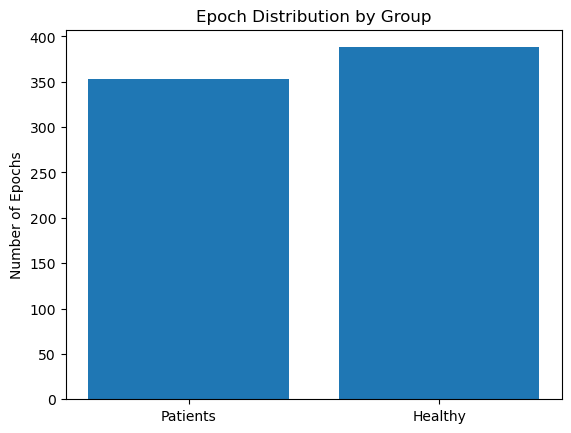

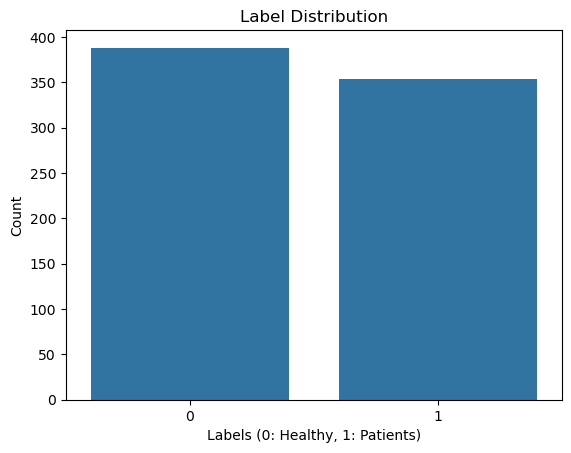

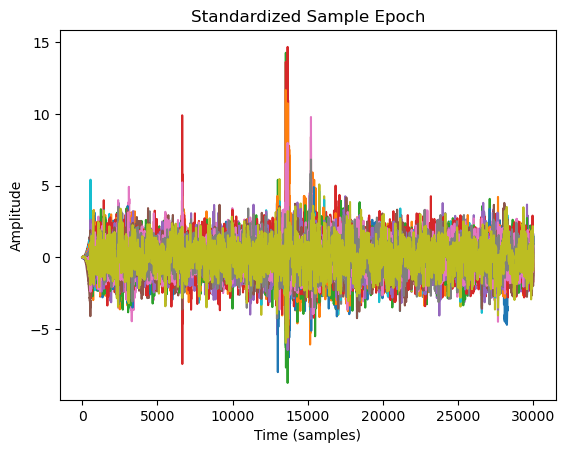

Training label distribution: [310. 282.]
Testing label distribution: [78. 71.]


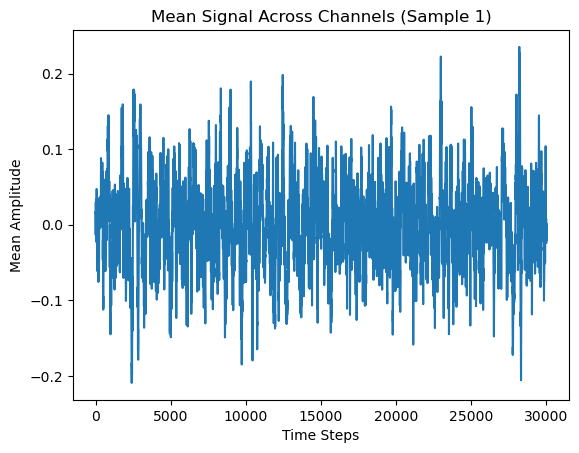

In [25]:
# Training and Evaluation
print("Initializing data...")
# Assuming the data has been preprocessed
train_data, train_labels, test_data, test_labels = preprocess_data(files_path)

In [6]:
import os
import pandas as pd
import numpy as np
import mne
from ssqueezepy import cwt
import torch
import torch.nn as nn
import torchmetrics
import timm
from sklearn.model_selection import StratifiedGroupKFold
from torch.utils.data import DataLoader, Dataset
from sklearn.metrics import classification_report, roc_auc_score, accuracy_score, f1_score
from glob import glob
from sklearn.model_selection import StratifiedKFold

In [17]:
# Early stopping parameters
patience = 5  # Number of epochs to wait for improvement
best_test_f1 = 0  # Initialize the best F1 score
patience_counter = 0  # Counter to track epochs without improvement

lr = 0.001
batch_size = 32
num_epochs = 50

# Initialize model, optimizer, and loss function
model = ChronoNet()  # Replace with your model
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss()

# Prepare datasets
train_dataset = TensorDataset(torch.Tensor(train_data), torch.Tensor(train_labels))
test_dataset = TensorDataset(torch.Tensor(test_data), torch.Tensor(test_labels))

# DataLoaders with current batch size
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

# Training loop
for epoch in range(num_epochs):
    print(f"Starting epoch {epoch + 1}")
    model.train()
    epoch_train_loss = 0
    epoch_train_preds = []
    epoch_train_labels = []

    for batch_idx, (X_batch, y_batch) in enumerate(train_loader):
        optimizer.zero_grad()
        # Forward pass
        y_pred = model(X_batch.permute(0, 2, 1))  # Ensure input shape matches the model's expectation
        # Convert one-hot encoded labels to class indices
        y_batch = torch.argmax(y_batch, dim=1)  # Now y_batch is of shape [batch_size]
        # Compute loss
        loss = criterion(y_pred, y_batch)
        loss.backward()
        optimizer.step()
        # Apply softmax for predictions (if needed for metrics)
        y_pred_prob = torch.softmax(y_pred, dim=1)
        y_pred_label = torch.argmax(y_pred_prob, dim=1)
    
        # Track metrics
        epoch_train_loss += loss.item()
        epoch_train_preds.extend(y_pred_label.detach().cpu().numpy())
        epoch_train_labels.extend(y_batch.cpu().numpy())

    # Metrics for training
    epoch_train_preds = np.array(epoch_train_preds).flatten()
    epoch_train_labels = np.array(epoch_train_labels).flatten()
    train_accuracy = accuracy_score(epoch_train_labels, epoch_train_preds)
    train_f1 = f1_score(epoch_train_labels, epoch_train_preds)
    print(f"Epoch {epoch + 1} - Train Loss: {epoch_train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}, Train F1: {train_f1:.4f}")

    # Evaluate on test data
    model.eval()
    test_preds = []
    test_labels_list = []

    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            y_pred = model(X_batch.permute(0, 2, 1))  # Ensure correct input shape
            y_pred_label = torch.argmax(y_pred, dim=1)  # Class predictions
            y_batch = torch.argmax(y_batch, dim=1)  # Convert one-hot labels back to indices
            test_preds.extend(y_pred_label.cpu().numpy())
            test_labels_list.extend(y_batch.cpu().numpy())

    # Compute metrics
    test_accuracy = accuracy_score(test_labels_list, test_preds)
    test_f1 = f1_score(test_labels_list, test_preds)
    conf_matrix = confusion_matrix(test_labels_list, test_preds)

    print(f"Confusion Matrix:\n{conf_matrix}")
    print(f"Test Accuracy: {test_accuracy:.4f}, Test F1: {test_f1:.4f}")

    # Early stopping logic
    if test_f1 > best_test_f1:
        best_test_f1 = test_f1
        patience_counter = 0
        print(f"Improved F1: {best_test_f1:.4f}. Saving the model...")
        # Save model if needed
        torch.save(model, "best_model_ChronoNet.pth")
    else:
        patience_counter += 1
        print(f"No improvement for {patience_counter} epoch(s).")

    if patience_counter >= patience:
        print("Early stopping triggered.")
        break

Starting epoch 1
Epoch 1 - Train Loss: 13.0978, Train Accuracy: 0.5236, Train F1: 0.4125
Confusion Matrix:
[[66 12]
 [47 24]]
Test Accuracy: 0.6040, Test F1: 0.4486
Improved F1: 0.4486. Saving the model...
Starting epoch 2
Epoch 2 - Train Loss: 11.1765, Train Accuracy: 0.8378, Train F1: 0.8229
Confusion Matrix:
[[78  0]
 [53 18]]
Test Accuracy: 0.6443, Test F1: 0.4045
No improvement for 1 epoch(s).
Starting epoch 3
Epoch 3 - Train Loss: 9.5656, Train Accuracy: 0.8716, Train F1: 0.8598
Confusion Matrix:
[[73  5]
 [24 47]]
Test Accuracy: 0.8054, Test F1: 0.7642
Improved F1: 0.7642. Saving the model...
Starting epoch 4
Epoch 4 - Train Loss: 8.5483, Train Accuracy: 0.9527, Train F1: 0.9495
Confusion Matrix:
[[55 23]
 [ 7 64]]
Test Accuracy: 0.7987, Test F1: 0.8101
Improved F1: 0.8101. Saving the model...
Starting epoch 5
Epoch 5 - Train Loss: 8.0308, Train Accuracy: 0.9814, Train F1: 0.9803
Confusion Matrix:
[[66 12]
 [12 59]]
Test Accuracy: 0.8389, Test F1: 0.8310
Improved F1: 0.8310. Sav

**EEG Model Code**

In [1]:
import os
import numpy as np
import mne
from ssqueezepy import cwt
import torch
import torch.nn as nn
import torchmetrics
from sklearn.model_selection import StratifiedKFold
from torch.utils.data import DataLoader, Dataset
from sklearn.metrics import roc_auc_score, f1_score

**EEG Data Pre-processing**

In [2]:
# Set MNE log level to suppress excessive output
mne.set_log_level('ERROR')

# Paths and File Handling
main_path = '/Users/rayanbeshawri/Downloads/Senior/DataSets/EEG Dataset/derivatives/EEG'
all_files = [file for file in os.listdir(main_path) if file.endswith('.set')]

# Separate files into patient and healthy groups
patient_files = [os.path.join(main_path, file) for file in all_files if int(file.split('_')[0].split('-')[1]) <= 36]
healthy_files = [os.path.join(main_path, file) for file in all_files if int(file.split('_')[0].split('-')[1]) >= 37]

file_paths = patient_files + healthy_files
labels = [1] * len(patient_files) + [0] * len(healthy_files)  # 1 = patient, 0 = healthy

In [3]:
# Load EEG Data
def load_eeg_data(file_path, target_length=None):
    raw = mne.io.read_raw_eeglab(file_path, preload=True)
    raw.filter(l_freq=1.0, h_freq=50.0)  # Bandpass filter
    raw_data = raw.get_data()
    
    if target_length:
        n_channels, n_samples = raw_data.shape
        if n_samples > target_length:
            raw_data = raw_data[:, :target_length]  # Truncate
        elif n_samples < target_length:
            padding = np.zeros((n_channels, target_length - n_samples))
            raw_data = np.hstack([raw_data, padding])
    
    # Normalize
    raw_data = (raw_data - np.mean(raw_data, axis=-1, keepdims=True)) / np.std(raw_data, axis=-1, keepdims=True)
    return raw_data

In [4]:
def convert_to_epochs(file_paths, labels, epoch_duration=10, overlap=5, sampling_rate=128, max_epochs_per_subject=500):
    epochs_data = []
    epoch_labels = []
    n_samples_per_epoch = epoch_duration * sampling_rate
    step_size = (epoch_duration - overlap) * sampling_rate

    for file_path, label in zip(file_paths, labels):
        raw_data = load_eeg_data(file_path, target_length=None)
        n_channels, n_samples = raw_data.shape

        subject_epochs = []
        for start in range(0, n_samples - n_samples_per_epoch + 1, step_size):
            end = start + n_samples_per_epoch
            subject_epochs.append(raw_data[:, start:end])

        # Ensure no more than max_epochs_per_subject epochs
        if len(subject_epochs) > max_epochs_per_subject:
            sampled_epochs = np.random.choice(len(subject_epochs), max_epochs_per_subject, replace=False)
            subject_epochs = [subject_epochs[i] for i in sampled_epochs]

        epochs_data.extend(subject_epochs)
        epoch_labels.extend([label] * len(subject_epochs))

    epochs_data = np.array(epochs_data)
    epoch_labels = np.array(epoch_labels)
    return epochs_data, epoch_labels

In [5]:
# Generate Scaleograms
def generate_scaleograms(epochs_data, output_dir):
    os.makedirs(output_dir, exist_ok=True)
    for idx, trial in enumerate(epochs_data):
        output_file = os.path.join(output_dir, f"scaleogram_{idx + 1}.npy")
        if os.path.exists(output_file):
            continue  # Skip already processed files
        Wx, _ = cwt(trial, 'morlet')
        np.save(output_file, np.abs(Wx))
        if (idx + 1) % 100 == 0:
            print(f"Processed {idx + 1}/{len(epochs_data)} epochs.")
    print("Scaleogram generation complete.")

In [6]:
# Custom Dataset
class EEGDataset(Dataset):
    def __init__(self, scaleogram_files, labels, augment=False):
        self.scaleogram_files = scaleogram_files
        self.labels = labels
        self.augment = augment

    def __getitem__(self, index):
        x = np.load(self.scaleogram_files[index])
        y = self.labels[index]
        x = (x - np.min(x)) / (np.max(x) - np.min(x))  # Normalize
        return torch.tensor(x, dtype=torch.float32), torch.tensor(y, dtype=torch.float32)

    def __len__(self):
        return len(self.scaleogram_files)

**EEG Scaleogram 2D Model**

In [7]:
# Neural Network Model
class OurModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.reduce_channels = nn.Conv2d(1280, 14, kernel_size=1)
        self.model = timm.create_model('resnest26d', pretrained=True)
        self.model.conv1[0] = nn.Conv2d(14, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        self.fc1 = nn.Linear(1000, 500)
        self.fc2 = nn.Linear(500, 1)
        self.criterion = nn.BCEWithLogitsLoss()

    def forward(self, x):
        x = x.permute(0, 3, 1, 2)  # Reorder dimensions for the model
        x = self.reduce_channels(x)
        x = self.model(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = self.fc2(x)
        x = torch.sigmoid(x)
        return x

In [8]:
# Paths for Scaleograms
scaleogram_dir = "/Users/rayanbeshawri/Downloads/Senior/DataSets/EEG Dataset/derivatives/scaleograms"
epochs_data, epoch_labels = convert_to_epochs(file_paths, labels)
generate_scaleograms(epochs_data, scaleogram_dir)

scaleogram_files = [
    os.path.join(scaleogram_dir, f"scaleogram_{i + 1}.npy") for i in range(len(epochs_data))
]

Scaleogram generation complete.


In [9]:
# Stratified K-Fold Cross-Validation
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
for train_idx, val_idx in skf.split(scaleogram_files, epoch_labels):
    break  # Just one split for demonstration

train_data = EEGDataset([scaleogram_files[i] for i in train_idx], epoch_labels[train_idx], augment=True)
val_data = EEGDataset([scaleogram_files[i] for i in val_idx], epoch_labels[val_idx])

train_loader = DataLoader(train_data, batch_size=16, shuffle=True)
val_loader = DataLoader(val_data, batch_size=16)

In [14]:
from sklearn.metrics import f1_score, confusion_matrix
from torch.optim.lr_scheduler import ReduceLROnPlateau
import torchmetrics.functional
import numpy as np

# Early stopping parameters
patience = 5

best_val_f1 = float('-inf')  # Track the best validation F1 score
epochs_no_improve = 0

model = OurModel()
# Optimizer with L2 Regularization (weight_decay)
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001, weight_decay=1e-4)

# Learning rate scheduler
scheduler = ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=2, verbose=True)

# Training Loop
epochs = 50
for epoch in range(epochs):
    print(f"Starting Epoch {epoch + 1}/{epochs}...")
    model.train()
    running_loss = 0.0
    running_accuracy = 0.0
    running_f1 = 0.0
    total_conf_matrix = np.zeros((2, 2), dtype=int)

    for batch_idx, (x, y) in enumerate(train_loader):
        optimizer.zero_grad()
        outputs = model(x)
        loss = model.criterion(outputs.squeeze(), y)
        loss.backward()
        optimizer.step()

        # Metrics
        preds_sigmoid = torch.sigmoid(outputs).squeeze() > 0.5
        acc = torchmetrics.functional.accuracy(preds_sigmoid, y.int(), task="binary")
        f1 = f1_score(y.cpu(), preds_sigmoid.cpu(), zero_division=1)

        # Update confusion matrix
        conf_matrix = confusion_matrix(y.cpu(), preds_sigmoid.cpu(), labels=[0, 1])
        total_conf_matrix += conf_matrix

        running_loss += loss.item()
        running_accuracy += acc.item()
        running_f1 += f1

    # Epoch Metrics
    epoch_loss = running_loss / len(train_loader)
    epoch_accuracy = running_accuracy / len(train_loader)
    epoch_f1 = running_f1 / len(train_loader)
    print(f"Epoch {epoch + 1}/{epochs} - Loss: {epoch_loss:.4f}, "
          f"Accuracy: {epoch_accuracy:.4f}, F1: {epoch_f1:.4f}")
    print(f"Confusion Matrix:\n{total_conf_matrix}")

    # Validation Loop
    model.eval()
    val_loss = 0.0
    val_accuracy = 0.0
    val_f1 = 0.0
    val_conf_matrix = np.zeros((2, 2), dtype=int)

    with torch.no_grad():
        for x, y in val_loader:
            outputs = model(x)
            loss = model.criterion(outputs.squeeze(), y)

            # Metrics
            preds_sigmoid = torch.sigmoid(outputs).squeeze() > 0.5
            acc = torchmetrics.functional.accuracy(preds_sigmoid, y.int(), task="binary")
            f1 = f1_score(y.cpu(), preds_sigmoid.cpu(), zero_division=1)

            # Update confusion matrix
            conf_matrix = confusion_matrix(y.cpu(), preds_sigmoid.cpu(), labels=[0, 1])
            val_conf_matrix += conf_matrix

            val_loss += loss.item()
            val_accuracy += acc.item()
            val_f1 += f1

    val_loss /= len(val_loader)
    val_accuracy /= len(val_loader)
    val_f1 /= len(val_loader)

    print(f"Validation - Loss: {val_loss:.4f}, "
          f"Accuracy: {val_accuracy:.4f}, F1: {val_f1:.4f}")
    print(f"Validation Confusion Matrix:\n{val_conf_matrix}")

    # Adjust learning rate based on validation F1 score
    scheduler.step(val_f1)

    # Early Stopping Logic (based on validation F1 score)
    if val_f1 > best_val_f1:
        best_val_f1 = val_f1
        epochs_no_improve = 0
        print("Validation F1 score improved. Saving the model...")
        torch.save(model, "best_model_scaleogram.pth")
    else:
        epochs_no_improve += 1
        print(f"No improvement in validation F1 for {epochs_no_improve} epoch(s).")

    if epochs_no_improve >= patience:
        print("Early stopping triggered. Stopping training.")
        break

/opt/anaconda3/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Starting Epoch 1/50...
Epoch 1/50 - Loss: 0.6567, Accuracy: 0.5119, F1: 0.6605
Confusion Matrix:
[[  73 2247]
 [  18 2302]]
Validation - Loss: 0.6399, Accuracy: 0.5479, F1: 0.4937
Validation Confusion Matrix:
[[ 70 510]
 [ 12 568]]
Validation F1 score improved. Saving the model...
Starting Epoch 2/50...
Epoch 2/50 - Loss: 0.6209, Accuracy: 0.6573, F1: 0.7158
Confusion Matrix:
[[ 976 1344]
 [ 246 2074]]
Validation - Loss: 0.6150, Accuracy: 0.7577, F1: 0.4301
Validation Confusion Matrix:
[[425 155]
 [126 454]]
No improvement in validation F1 for 1 epoch(s).
Starting Epoch 3/50...
Epoch 3/50 - Loss: 0.6229, Accuracy: 0.6864, F1: 0.7180
Confusion Matrix:
[[1247 1073]
 [ 382 1938]]
Validation - Loss: 0.6136, Accuracy: 0.7594, F1: 0.4702
Validation Confusion Matrix:
[[390 190]
 [ 89 491]]
No improvement in validation F1 for 2 epoch(s).
Starting Epoch 4/50...
Epoch 4/50 - Loss: 0.5990, Accuracy: 0.7625, F1: 0.7794
Confusion Matrix:
[[1501  819]
 [ 283 2037]]
Validation - Loss: 0.5892, Accurac

**Two EEG Model Ensemble Learning**

In [11]:
import os
import numpy as np
import mne
import matplotlib.pyplot as plt
from glob import glob
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense, Dropout, Input
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import GroupKFold
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.metrics import AUC, Precision, Recall
import torch
import torch.nn as nn
from sklearn.model_selection import train_test_split
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import GroupKFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
from sklearn.model_selection import StratifiedKFold
import pandas as pd
from sklearn.model_selection import ParameterGrid
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_auc_score
import os
import pandas as pd
import numpy as np
import mne
from ssqueezepy import cwt, morlet
import torch
import torch.nn as nn
import torchmetrics
import timm
from sklearn.model_selection import StratifiedGroupKFold
from torch.utils.data import DataLoader, Dataset
from sklearn.metrics import classification_report, roc_auc_score, accuracy_score, f1_score
from glob import glob
from sklearn.model_selection import StratifiedKFold

In [10]:
import numpy as np
import torch
import mne
from sklearn.preprocessing import StandardScaler
import pywt
import time  # Import the time module

# File path
file_path = '/Users/rayanbeshawri/Downloads/Senior/DataSets/EEG Dataset/derivatives/sub-019_task-eyesclosed_eeg.set'

# Load weights
print("Loading model weights...")
start_time = time.time()  # Start the timer
model_1d = torch.load('best_model_ChronoNet.pth', map_location="cpu")
model_2d = torch.load('best_model_scaleogram.pth', map_location="cpu")
print(f"Model weights loaded in {time.time() - start_time:.2f} seconds.")

# Set evaluation mode
print("Setting models to evaluation mode...")
model_1d.eval()
model_2d.eval()

def preprocess_1d(file_path, duration=60, overlap=0):
    """
    Preprocess a single EEG file and prepare it for model input.
    Args:
        file_path (str): Path to the EEG file in .set format.
        duration (int): Epoch duration in seconds.
        overlap (int): Overlap between epochs in seconds.

    Returns:
        torch.Tensor: Preprocessed EEG data ready for model input (shape: [samples, time_steps, channels]).
    """
    try:
        # Load EEG file
        data = mne.io.read_raw_eeglab(file_path, preload=True)
    except Exception as e:
        print(f"Error loading file {file_path}: {e}")
        raise e

    # Check sampling rate
    sampling_rate = data.info['sfreq']

    # Create fixed-length epochs (duration in seconds)
    epochs = mne.make_fixed_length_epochs(data, duration=duration, overlap=overlap)
    epoch_data = epochs.get_data()  # Shape: (n_epochs, n_channels, n_samples)

    if epoch_data.size == 0:
        raise ValueError(f"No valid data epochs found in {file_path}.")

    # Standardize each epoch (z-score normalization)
    scaler = StandardScaler()
    standardized_data = np.array([scaler.fit_transform(epoch.T).T for epoch in epoch_data])

    # Reshape data for ChronoNet: (samples, time_steps, channels)
    reshaped_data = np.moveaxis(standardized_data, 1, 2)  # Shape: (samples, time_steps, channels)

    # Convert to PyTorch tensor
    input_tensor = torch.Tensor(reshaped_data)

    # Transpose to match model input shape: [batch_size, time_steps, channels]
    input_tensor = input_tensor.transpose(1, 2)  # Shape: (31, 30000, 19)

    return input_tensor

# Preprocessing for 2D input with CWT and Morlet wavelet
def preprocess_2d(file_path, epoch_duration=10, overlap=5, sampling_rate=128, target_length=None):
    """
    This function processes EEG data, converts it to epochs, generates scaleograms, 
    and prepares the input in the correct shape for the model.
    Args:
        file_path (str): Path to the EEG file in .set format.
        epoch_duration (int): Duration of each epoch in seconds.
        overlap (int): Overlap between consecutive epochs in seconds.
        sampling_rate (int): Sampling rate of the EEG data.
        target_length (int): Target length for the data in samples.

    Returns:
        torch.Tensor: Preprocessed data ready for model input with shape [batch_size, channels, time_steps, height].
    """
    # Load EEG data
    raw = mne.io.read_raw_eeglab(file_path, preload=True)
    raw.filter(l_freq=1.0, h_freq=50.0)  # Bandpass filter
    raw_data = raw.get_data()

    # Padding or truncating data to match target_length if provided
    if target_length:
        n_channels, n_samples = raw_data.shape
        if n_samples > target_length:
            raw_data = raw_data[:, :target_length]  # Truncate
        elif n_samples < target_length:
            padding = np.zeros((n_channels, target_length - n_samples))
            raw_data = np.hstack([raw_data, padding])

    # Normalize the data
    raw_data = (raw_data - np.mean(raw_data, axis=-1, keepdims=True)) / np.std(raw_data, axis=-1, keepdims=True)

    # Convert to epochs
    n_channels, n_samples = raw_data.shape
    epoch_length = epoch_duration * sampling_rate
    step_size = (epoch_duration - overlap) * sampling_rate
    epochs = []
    for start in range(0, n_samples - epoch_length + 1, step_size):
        epochs.append(raw_data[:, start:start + epoch_length])

    epochs_data = np.array(epochs)

    # Generate Scaleograms (using CWT with morlet wavelet)
    scaleograms = []
    for epoch in epochs_data:
        # For each channel, apply CWT
        epoch_scaleograms = []
        for ch_data in epoch:
            Wx, _ = cwt(ch_data, 'morlet')  # Use ch_data instead of trial
            epoch_scaleograms.append(np.abs(Wx))
        scaleograms.append(np.array(epoch_scaleograms))
    
    scaleograms = np.array(scaleograms)

    # Reshape scaleograms to match model input shape: [batch_size, channels, time_steps, height]
    scaleograms = scaleograms[..., np.newaxis]  # Add height dimension (e.g., just 1 if not used)
    
    # Convert to PyTorch tensor
    input_tensor = torch.tensor(scaleograms, dtype=torch.float32).squeeze(-1) 
    
    return input_tensor

Loading model weights...
Model weights loaded in 0.08 seconds.
Setting models to evaluation mode...


/var/folders/s_/m1z8_7sn2mq35y0cvv16050h0000gn/T/ipykernel_56210/2951621075.py:14: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_1d = torch.load('best_model_ChronoNet.

In [11]:
# Preprocess the data
print("Starting data preprocessing...")
start_time = time.time()
data_1d = preprocess_1d(file_path, duration=60, overlap=30)
data_2d = preprocess_2d(file_path)
print(f"Data preprocessing completed in {time.time() - start_time:.2f} seconds.")

Starting data preprocessing...
Data preprocessing completed in 238.08 seconds.


In [12]:
# Run the modelsB HN 
print("Running models...")
with torch.no_grad():
    output_1d = model_1d(data_1d)
    output_2d = model_2d(data_2d)

Running models...


In [13]:
# Ensemble
threshold = 0.5
prob_1d = output_1d.numpy().mean()  # Mean probability across all epochs
class_2d = output_2d.numpy().mean() > threshold  # Binary output from 2D model
final_decision = (prob_1d > threshold) or class_2d

# Display the result
print(f"1D Model Probability: {prob_1d:.4f}")
print(f"2D Model Classification: {class_2d}")
print(f"Final Decision: {'Alzheimer\'s Detected' if final_decision else 'No Alzheimer\'s Detected'}")

1D Model Probability: 0.5000
2D Model Classification: False
Final Decision: No Alzheimer's Detected
